# Daily statistics from hourly ERA5 data

In [11]:
# If first time running, uncomment the line below to install any additional dependancies
# !bash requirements-for-notebooks.sh

In [12]:
from earthkit import aggregate as ek_aggregate
from earthkit import data as ek_data

from earthkit.data.testing import earthkit_remote_test_data_file
ek_data.settings.set("cache-policy", "user")

import matplotlib.pyplot as plt

## Load some test data

All `earthkit-climate` methods can be called with `earthkit-data` objects (Readers and Wrappers) or with the 
pre-loaded `xarray`.

In this example we will use hourly ERA5 2m temperature data on a 0.5x0.5 spatial grid for the year 2015 as
our physical data.

First we download (if not already cached) lazily load the ERA5 data (please see tutorials in `earthkit-data` for more details in cache management).

We inspect the data using the describe method and see we have some 2m air temperature data. For a more detailed representation of the data you can use the to_xarray method.

In [13]:
# Get some demonstration ERA5 data, this could be any url or path to an ERA5 grib or netCDF file.
remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_2015.grib")
era5_data = ek_data.from_source("url", remote_era5_file)
# era5_data.to_xarray()
era5_data.describe()

,,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
shortName,typeOfLevel,,,,,,,,,
2t,surface,0,"20150301,20150302,...","0,1800,...",0,167,ea,oper,an,0001


## Calculate the daily mean and standard deviation of the ERA5 data

We can calculate the daily mean using daily_mean method in the temporal module. There are similar daily aggregation methods for the `daily_median`, `daily_min`, `daily_max`, `daily_std`, `daily_sum`, and all these again for monthly aggregations in the form `monthly_XXX`.

**eartkit-aggregate** is able to understand any data object understood by **earthkit-data** as input. The **eartkit-aggregate** computation is based on xarray datacubes, therefore the returned object is an `xarray.Dataset`. To convert this to an Earthit object you could use the **earthkit-data** method, `from_object`.

If the input data is provided an `xarray.Dataset` then the return object is `xarray.Dataset` and if the input is an `xarray.DataArray` then the return object is an `xarray.DataArray`.


In [14]:
era5_daily_mean = ek_aggregate.temporal.daily_mean(era5_data)
era5_daily_std = ek_aggregate.temporal.daily_std(era5_data)
era5_daily_mean
# ek_data.from_object(era5_daily_mean)

<xarray.Dataset> Size: 82MB
Dimensions:    (time: 365, number: 1, step: 1, surface: 1, latitude: 201,
                longitude: 281)
Coordinates:
  * number     (number) int64 8B 0
  * step       (step) timedelta64[ns] 8B 00:00:00
  * surface    (surface) float64 8B 0.0
  * latitude   (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * time       (time) datetime64[ns] 3kB 2015-01-01 2015-01-02 ... 2015-12-31
Data variables:
    t2m        (time, number, step, surface, latitude, longitude) float32 82MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-12T08:58 GRIB to CDM+CF via cfgrib-0.9.1...

### Calculate the monthly mean and standard deviation

In [15]:
era5_monthly_mean = ek_aggregate.temporal.monthly_mean(era5_data)
era5_monthly_std = ek_aggregate.temporal.monthly_std(era5_data)
era5_monthly_std

<xarray.Dataset> Size: 3MB
Dimensions:    (time: 12, number: 1, step: 1, surface: 1, latitude: 201,
                longitude: 281)
Coordinates:
  * number     (number) int64 8B 0
  * step       (step) timedelta64[ns] 8B 00:00:00
  * surface    (surface) float64 8B 0.0
  * latitude   (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * time       (time) datetime64[ns] 96B 2015-01-01 2015-02-01 ... 2015-12-01
Data variables:
    t2m        (time, number, step, surface, latitude, longitude) float32 3MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-12T08:59 GRIB to CDM+CF via cfgrib-0.9.1...

## Calculate a rolling mean with a 50 timestep window

To calculate a rolling mean along the time dimension you can use the rolling_reduce function.

NOTE: An improved API to the rolling_reduce method is an ongoing task

In [16]:
era5_rolling = ek_aggregate.temporal.rolling_reduce(
    era5_data, 50, how_reduce="mean", center=True,
)
era5_rolling

<xarray.Dataset> Size: 330MB
Dimensions:     (number: 1, time: 1460, step: 1, surface: 1, latitude: 201,
                 longitude: 281)
Coordinates:
  * number      (number) int64 8B 0
  * time        (time) datetime64[ns] 12kB 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 8B 00:00:00
  * surface     (surface) float64 8B 0.0
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] 12kB dask.array<chunksize=(1460, 1), meta=np.ndarray>
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 330MB dask.array<chunksize=(1, 1459, 1, 1, 201, 281), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-12T08:59 GRIB to CDM+CF via cfgrib-0.9.1...

## Account for non-UTC timezones

There is a time_shift argument which can be used to account for non-UTC time zones:

In [17]:
era5_daily_mean_p12 = ek_aggregate.temporal.daily_mean(era5_data, time_shift={"hours": 12})
era5_daily_mean_p12

<xarray.Dataset> Size: 83MB
Dimensions:    (time: 366, number: 1, step: 1, surface: 1, latitude: 201,
                longitude: 281)
Coordinates:
  * number     (number) int64 8B 0
  * step       (step) timedelta64[ns] 8B 00:00:00
  * surface    (surface) float64 8B 0.0
  * latitude   (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * time       (time) datetime64[ns] 3kB 2015-01-01 2015-01-02 ... 2016-01-01
Data variables:
    t2m        (time, number, step, surface, latitude, longitude) float32 83MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-12T08:59 GRIB to CDM+CF via cfgrib-0.9.1...

## Plot a random point location to see the different aggregation methods

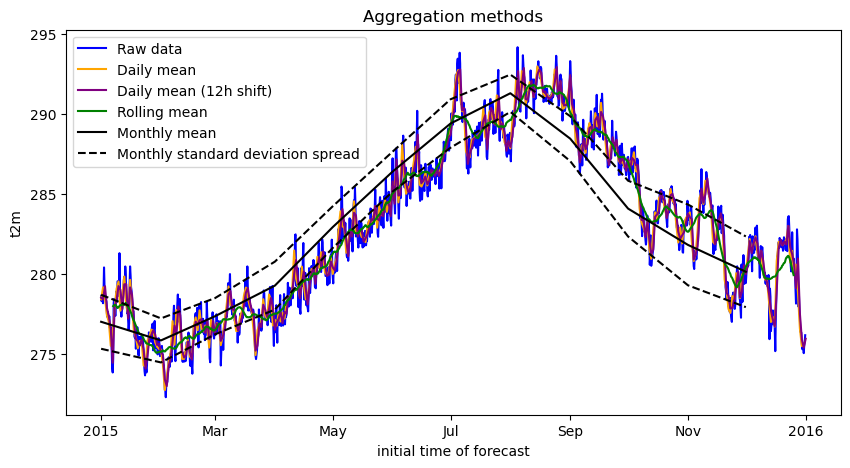

In [18]:
isel_kwargs = {"latitude":100, "longitude":100}

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))

era5_data.to_xarray().t2m.isel(**isel_kwargs).plot(label='Raw data', ax=ax, color='blue')
era5_daily_mean.t2m.isel(**isel_kwargs).plot(
    label='Daily mean', ax=ax, color='orange'
)

era5_daily_mean_p12.t2m.isel(**isel_kwargs).plot(
    label='Daily mean (12h shift)', ax=ax, color='purple'
)

# # To add the daily spread as orange dotted lines:
# upper_d = era5_daily_mean.t2m + era5_daily_std.t2m
# lower_d = era5_daily_mean.t2m - era5_daily_std.t2m
# upper_d.isel(**isel_kwargs).plot(ax=ax, label='Daily standard deviation spread', linestyle='--', color='orange')
# lower_d.isel(**isel_kwargs).plot(ax=ax, linestyle='--', color='orange')

# Add the rolling mean as green line:
era5_rolling.t2m.isel(**isel_kwargs).plot(label='Rolling mean', ax=ax, color='green')

# Add the monthly mean as a black solid line and spread as black dotted lines:
era5_monthly_mean.t2m.isel(**isel_kwargs).plot(label='Monthly mean', ax=ax, color='black')
upper_m = era5_monthly_mean.t2m + era5_monthly_std.t2m
lower_m = era5_monthly_mean.t2m - era5_monthly_std.t2m
upper_m.isel(**isel_kwargs).plot(ax=ax, label='Monthly standard deviation spread', linestyle='--', color='black')
lower_m.isel(**isel_kwargs).plot(ax=ax, linestyle='--', color='black')


# figure = fig[0].get_figure()
ax.legend(loc=2)
ax.set_title("Aggregation methods")
plt.show()